In [1]:
import pandas as pd
import numpy as np
from glob import glob
import obspy
from obspy.clients.fdsn import Client
import matplotlib.pyplot as plt
from tqdm import tqdm

from obspy import UTCDateTime
from dateutil import parser
from pytz import timezone
import obspy
from obspy.clients.fdsn.mass_downloader import CircularDomain, \
    Restrictions, MassDownloader

import yaml


# importing the dependencies. 

import scipy as sc
from scipy import signal
import h5py

from obspy.signal.filter import envelope

import tsfel
import random
from datetime import timedelta
import calendar
from tsfel import time_series_features_extractor
from sklearn.preprocessing import StandardScaler

from scipy import stats

#%config InlineBackend.figure_format = "png"

#from Feature_Extraction import compute_hibert

import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

# displaying all columns from pandas dataframe
# Set display options to show all columns
pd.set_option('display.max_columns', None)

from sklearn.ensemble import RandomForestClassifier
from joblib import dump, load


import time
from datetime import datetime
import seaborn as sns

import sys
sys.path.append('../feature_extraction_scripts/physical_feature_extraction_scripts/')
import seis_feature


sys.path.append('../src')
from utils import apply_cosine_taper
from utils import butterworth_filter
from utils import resample_array
import matplotlib.lines as mlines

import tsfel
cfg_file = tsfel.get_features_by_domain()

import json
import os
from zenodo_get import zenodo_get



from obspy.clients.fdsn import Client

## Downloading the trained model files stored in an online repository

In [2]:
doi = '10.5281/zenodo.12765138'
files = zenodo_get([doi])

Title: Trained random forest models on 5000 traces per class based on updated features
Keywords: 
Publication date: 2024-07-17
DOI: 10.5281/zenodo.12765138
Total size: 441.0 MB

Link: https://zenodo.org/record/12765138/files/scaler_params_P_10_30_F_1_15_50.csv   size: 0.0 MB
scaler_params_P_10_30_F_1_15_50.csv is already downloaded correctly.

Link: https://zenodo.org/record/12765138/files/best_rf_model_all_features_P_10_100_F_1_10_50.joblib   size: 62.5 MB
best_rf_model_all_features_P_10_100_F_1_10_50.joblib is already downloaded correctly.

Link: https://zenodo.org/record/12765138/files/best_rf_model_all_features_P_10_30_F_1_15_50.joblib   size: 177.8 MB
best_rf_model_all_features_P_10_30_F_1_15_50.joblib is already downloaded correctly.

Link: https://zenodo.org/record/12765138/files/best_rf_model_all_features_P_50_100_F_1_10_50.joblib   size: 200.7 MB
best_rf_model_all_features_P_50_100_F_1_10_50.joblib is already downloaded correctly.

Link: https://zenodo.org/record/12765138/file

## Setting up the configuration

In [4]:
## Parameters to set before running this script. 
filename = 'P_10_30_F_1_15_50'

# We can also specify P_10_100_F_1_10_50 or P_50_100_F_1_10_50

## stride (s)
stride = 10

client = Client('IRIS')
before = 150
starttime = obspy.UTCDateTime(2024, 7, 2, 5, 11, 11) - before
dur = 300



stations_id = ['CC.SEP', 'CC.REM',  'CC.MIDE', 'CC.WESG', 'UW.NSP', 'UW.ROA']
location = '*'



## Custom Functions

In [11]:
def surface_event_detection(starttime = starttime, stations_id = stations_id, dur = dur, stride = stride,
                            location = location, filename = filename
):
    
    
    """"
    
    
    Output:
    
    result_stns
    
    """
   
    ## low cut frequency of a bandpass filter
    lowcut = 1
    ## high cut frequency of a bandpass filter
    highcut = int(filename.split('_')[5])

    ## window length for moving across the trace (s)
    win = int(filename.split('_')[1]) + int(filename.split('_')[2])

    ## samp_rate
    samp_freq = 100
    
    ## original sampling rate
    fs = 100
    num_corners = 4

    original_sr = 100
    
    ## new sampling rate
    new_sr = int(filename.split('_')[-1])
    
    
    ## reading the scaler parameters
    scaler_params = pd.read_csv('scaler_params_'+filename+'.csv')
    
    ## reading the trained model. 
    best_model = load('best_rf_model_all_features_'+filename+'.joblib')
    
    
    
    
    st_data_full = []
    result_stns = []
    index_stns = []
    prob_stns = []

    st_overall = []
    st_overall_data = []
    st_overall_times = []



    for stn_id in tqdm(stations_id):


        ## Extracting the station
        stn = stn_id.split('.')[1]

        ## Extracting the network
        network = stn_id.split('.')[0]

        st = []




        # So it will try to get vertical component data for a given station with priorities set as E,B or H, there is no reason for setting this priority. 

        # starttime set the starttime. 

        try:
            # Attempt to get waveform using 'EHZ' channel
            st += client.get_waveforms(starttime=starttime, endtime=starttime + dur, station=stn,
                                      network=network, channel='EHZ', location=location)
        except:
            try:
                # Attempt to get waveform using 'BHZ' channel
                st += client.get_waveforms(starttime=starttime, endtime=starttime + dur, station=stn,
                                          network=network, channel='BHZ', location=location)
            except:
                try:
                    # Use 'HHZ' channel as a fallback option
                    st += client.get_waveforms(starttime=starttime, endtime=starttime + dur, station=stn,
                                              network=network, channel='HHZ', location=location)
                except:
                    pass



        try: 
            
            
            # Now ideally all the data should come as a single trace file in stream but its possible there are data gaps and so the data is coming in 
            # multiple streams. 
            
            # detrending and resampling all the data to 100 Hz since thats 
            st = obspy.Stream(st)
            
            
            ## This is the general procedure followed in the processing of the raw data. 
            st.detrend()
            st = st.resample(samp_freq) 


            print(st)

            st_data_full = []

            ## Ideally the data should come in single stream (len(st) == 1) but if it comes in multiple streams
            ## We will take the first stream. 
            times = st[0].times()

            
            ## Now we are trying to merge the multiple traces in a given stream into a single trace. 
            for i in range(len(st)):
                st_data_full = np.hstack([st_data_full, st[i].data])


                if i+1 < len(st):
                    diff = st[i+1].stats.starttime - st[i].stats.endtime

                    times = np.hstack((times, st[i+1].times()+times[-1]+diff))




                    #print('Final times')

            # st_overall_data will store the full data array for each station. 
            st_overall_data.append(st_data_full)

            # st_overall will store the streams from all stations. 
            st_overall.append(st)


            # so clearly there can be significant differences between the length of st_overall and st_overall_data
            # if data comes in multiple streams. 

            # storing the times. length of times would be equal to number of st_overall_data and length of stations. 
            st_overall_times.append(times)

            # storing the trace data and times. 
            # So basically we are splitting the data of each station into list of arrays where each array is of length =. win *samp_rate. 
            # we are extracting a window and jumping by "shift" amount until the window of desired length cannot be extracted. 
            trace_data = [st_data_full[i:i+int(win*samp_freq)] for i in tqdm(range(0, len(st_data_full), stride*samp_freq)) if len(st_data_full[i:i+int(win*samp_freq)]) == int(win*samp_freq)]
            
            trace_times = [times[i] for i in tqdm(range(0, len(st_data_full), stride*samp_freq)) if len(st_data_full[i:i+int(win*samp_freq)]) == int(win*samp_freq)]


            ## applying processing to the trace. 
            trace_data = np.array(trace_data)
            tapered = apply_cosine_taper(trace_data, 10)
            filtered = butterworth_filter(tapered, lowcut, highcut, original_sr, num_corners, filter_type='bandpass')

            # Applying the normalization.
            norm = filtered / np.max(abs(np.stack(filtered)), axis=1)[:, np.newaxis]

            # Applying resampling
            norm = np.array([resample_array(arr, original_sr, new_sr) for arr in norm])


            result = []
            prob = []
            time = []
            index = []

            for i in range(len(norm)):


                try:    
                    tsfel_features = time_series_features_extractor(cfg_file, norm[i], fs= new_sr, verbose = 0)
                    physical_features = seis_feature.FeatureCalculator(norm[i],  fs = new_sr).compute_features()

                    final_features = pd.concat([tsfel_features, physical_features], axis=1)
                    columns = scaler_params['Feature'].values

                    features = final_features.loc[:, columns]
                    scaler_params.index = scaler_params['Feature'].values


                    for j in range(len(columns)):
                        features.loc[:, columns[j]] = (features.loc[:, columns[j]] - scaler_params.loc[columns[j],'Mean'])/scaler_params.loc[columns[j], 'Std Dev']


                    features['hod'] = (starttime).hour - 8
                    features['dow'] = (starttime).weekday
                    features['moy'] = (starttime).month



                    #features['E_20_50'] = 0.001
                    # extracting the results.
                    result.append(best_model.predict(features))
                    prob.append(best_model.predict_proba(features))
                    index.append(i)

                except:
                    pass




            result_stns.append(result)
            index_stns.append(index)
            prob_stns.append(prob)
            
        except:
            pass

    
    
    return result_stns, index_stns, prob_stns, st_overall, st_overall_data, st_overall_times



st_overall_data = []
st_overall_times = []
st_overall = []
result_stns = []
index_stns = []
prob_stns = []



def plot_detection_results(st_overall_data = st_overall_data, st_overall_times = st_overall_times, st_overall = st_overall, result_stns = result_stns, index_stns = index_stns, prob_stns = prob_stns, xlim = [0,dur], ev_markers = [before,dur], shift = stride, filename = filename):
    
    ## window length for moving across the trace (s)
    win = int(filename.split('_')[1]) + int(filename.split('_')[2])    
    
    plt.rcParams['xtick.labelsize'] = 16  # Font size for xtick labels
    plt.rcParams['ytick.labelsize'] = 20  # Font size for ytick labels

    fig, axs = plt.subplots(len(index_stns)+1, 1, figsize=(15, 3*(len(index_stns)+1)))

    for k in range(len(index_stns)):

        ## This is plotting the normalized data
        axs[k].plot(st_overall_times[k], st_overall_data[k] / np.max(abs(st_overall_data[k])))

        ## Setting the title of the plot
        axs[k].set_title(st_overall[k][0].id, fontsize=20)

        ## These are the colors of detection window. 
        colors = ['black', 'blue', 'white', 'red']
        for i in range(len(index_stns[k])):
            axs[k].axvline(shift * index_stns[k][i] + (win/2), ls='--', color=colors[int(result_stns[k][i])], alpha = 0.6)
            
        # Plot circles on top of the line plot
        for i in range(len(index_stns[k])):
            if result_stns[k][i] == 3:
                axs[k].scatter(shift * np.array(index_stns[k])[i] + (win/2), np.array(prob_stns[k])[:, :, 3][i], ec='k', marker='o', c='red', s=100, zorder=5)
            elif result_stns[k][i] == 0:
                axs[k].scatter(shift * np.array(index_stns[k])[i] + (win/2), np.array(prob_stns[k])[:, :, 0][i], ec='k', marker='o', c='black', s=100, zorder=5)
            elif result_stns[k][i] == 1:
                axs[k].scatter(shift * np.array(index_stns[k])[i] + (win/2), np.array(prob_stns[k])[:, :, 1][i], ec='k', marker='o', c='blue', s=100, zorder=5)
            else:
                axs[k].scatter(shift * np.array(index_stns[k])[i] + (win/2), np.array(prob_stns[k])[:, :, 2][i], ec='k', marker='o', c='white', s=100, zorder=5)

        # Create custom legend for circular markers
        legend_elements = [
           mlines.Line2D([], [], marker='o', color='red', mec = 'k', label='Prob (Su)', markersize=10),
            mlines.Line2D([], [], marker='o', color='k', mec = 'k', label='Prob (Eq)', markersize=10), 
            mlines.Line2D([], [], marker='o', color='white', mec = 'k',  label='Prob (No)', markersize=10),
             mlines.Line2D([], [], marker='o', color='blue', mec = 'k',  label='Prob (Exp)', markersize=10)
        ]
        axs[k].legend(handles=legend_elements, loc='upper right', fontsize=12)

        axs[k].set_xlabel('Time(s) since ' + str(starttime).split('.')[0], fontsize=20)
        axs[k].set_xlim(xlim[0], xlim[1])  # Set x-axis limits if needed
        axs[k].axvline(ev_markers[0], ls = '-', c = 'k', lw = 2)
        axs[k].axvline(ev_markers[1], ls = '-', c = 'k', lw = 2)
        
    
    
    
    # Finding the size of the biggest array
    max_size = max(max(arr) for arr in index_stns)+1

    print(max_size)

    # initializing different lists. 
    eq_probs = np.zeros([len(index_stns), max_size])
    exp_probs = np.zeros([len(index_stns), max_size])
    su_probs = np.zeros([len(index_stns), max_size])
    no_probs = np.zeros([len(index_stns), max_size])



    # saving the probabilities. 

    for i in range(len(index_stns)):
        for j in range(len(index_stns[i])):
            
            try:
                #print(f"Processing i={i}, j={j}")
                #print(f"index_stns[i][j] = {index_stns[i][j]}")
                #print(f"prob_stns[i][j] = {prob_stns[i][j]}")

                eq_probs[i, index_stns[i][j]] = prob_stns[i][j][0][0]
                exp_probs[i, index_stns[i][j]] = prob_stns[i][j][0][1]
                no_probs[i, index_stns[i][j]] = prob_stns[i][j][0][2]
                su_probs[i, index_stns[i][j]] = prob_stns[i][j][0][3]

            except IndexError as e:
                            print(f"IndexError: {e}")
                            #print(f"eq_probs shape: {eq_probs.shape}")
                            #print(f"index_stns[i]: {index_stns[i]}")
                            #print(f"prob_stns shape: {len(prob_stns)}, {len(prob_stns[i])}, {len(prob_stns[i][j][0])}")         
            
            
    mean_eq_probs = np.mean(eq_probs, axis = 0)
    mean_exp_probs = np.mean(exp_probs, axis = 0)
    mean_no_probs = np.mean(no_probs, axis = 0)
    mean_su_probs = np.mean(su_probs, axis = 0)
    
    
    axs[-1].set_title('Mean probabilities of each event type across all the stations', fontsize = 20)
    axs[-1].scatter(shift*np.arange(max_size)+(win/2), mean_eq_probs, marker = 'o', c = 'k', s = 100, ec = 'k')
    axs[-1].scatter(shift*np.arange(max_size)+(win/2), mean_exp_probs, marker = 'o', c = 'b', s = 100, ec = 'k')
    axs[-1].scatter(shift*np.arange(max_size)+(win/2),mean_no_probs, marker = 'o', c = 'white', s = 100, ec = 'k')
    axs[-1].scatter(shift*np.arange(max_size)+(win/2),mean_su_probs, marker = 'o', c = 'r', s = 100, ec= 'k')
    axs[-1].set_xlim(xlim[0], xlim[1])
    axs[-1].set_ylim(0, 1)
    axs[-1].set_ylabel('Mean Probability', fontsize = 20)
    axs[-1].legend(handles=legend_elements, loc='upper right', fontsize=12)
    fig.suptitle('Results for the model: '+filename, fontsize = 25)
    
    
    plt.tight_layout()  # Adjust subplots to avoid overlap
    plt.show()


## Downloading data, extracting features and outputing results

100%|██████████| 31/31 [00:00<00:00, 371495.50it/s]

100%|██████████| 31/31 [00:00<00:00, 539516.28it/s]

1 Trace(s) in Stream:
CC.SEP..BHZ | 2024-07-02T05:08:41.000000Z - 2024-07-02T05:13:41.010000Z | 100.0 Hz, 30002 samples



100%|██████████| 31/31 [00:00<00:00, 453043.29it/s]

100%|██████████| 31/31 [00:00<00:00, 572790.41it/s]

1 Trace(s) in Stream:
CC.REM..BHZ | 2024-07-02T05:08:41.000000Z - 2024-07-02T05:13:41.010000Z | 100.0 Hz, 30002 samples



 50%|█████     | 3/6 [00:13<00:11,  3.83s/it]

0 Trace(s) in Stream:



 67%|██████▋   | 4/6 [00:14<00:05,  2.61s/it]

0 Trace(s) in Stream:



 83%|████████▎ | 5/6 [00:14<00:01,  1.94s/it]

0 Trace(s) in Stream:



100%|██████████| 6/6 [00:15<00:00,  2.61s/it]

0 Trace(s) in Stream:

27


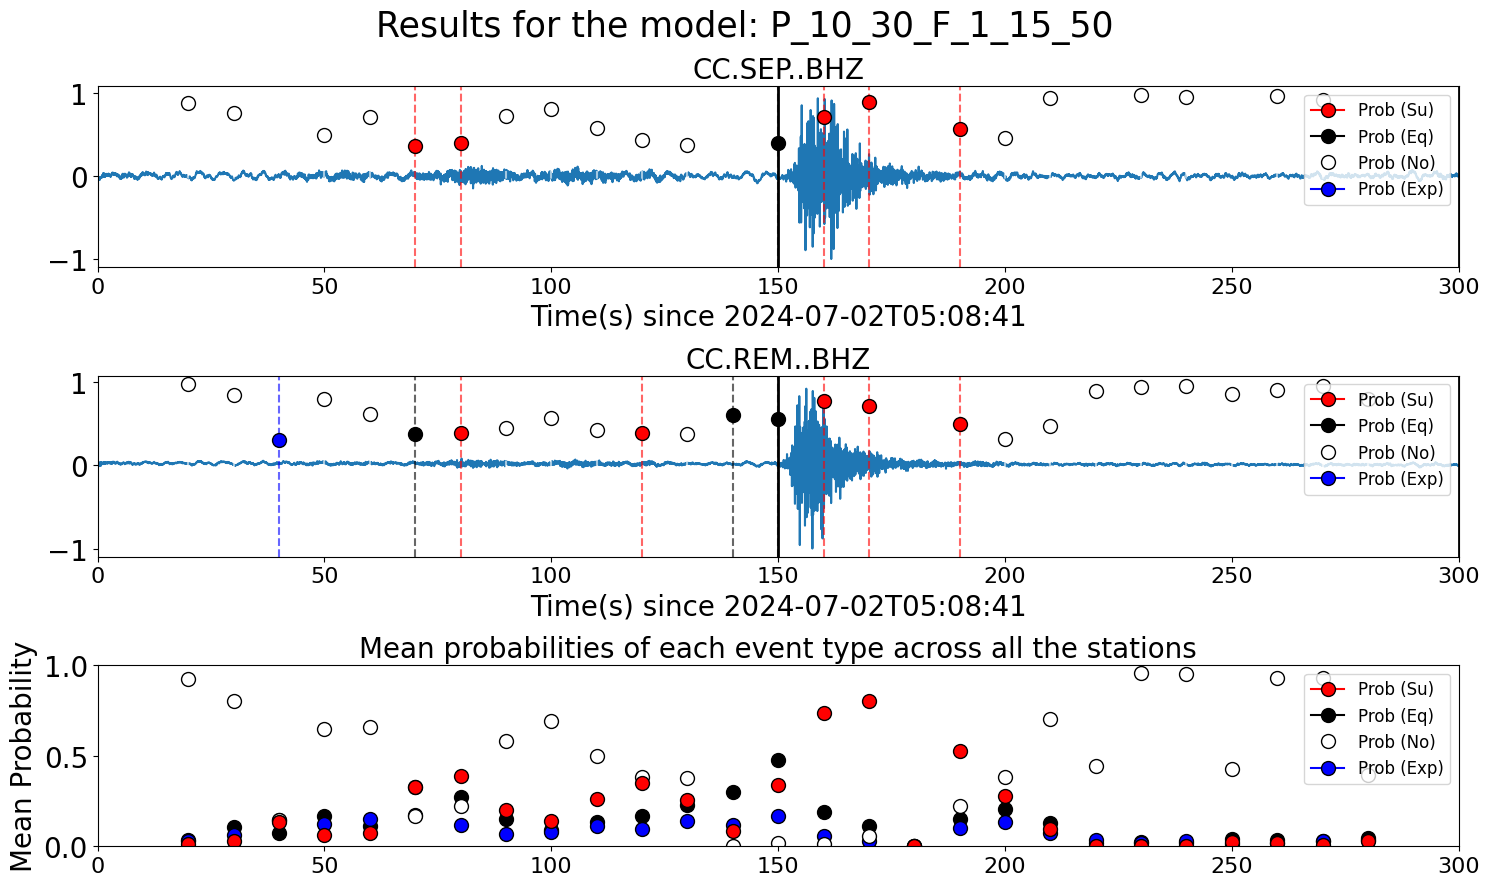

100%|██████████| 31/31 [00:00<00:00, 324247.94it/s]

100%|██████████| 31/31 [00:00<00:00, 386974.48it/s]

1 Trace(s) in Stream:
CC.SEP..BHZ | 2024-07-02T05:08:41.000000Z - 2024-07-02T05:13:41.010000Z | 100.0 Hz, 30002 samples



100%|██████████| 31/31 [00:00<00:00, 323441.35it/s]

100%|██████████| 31/31 [00:00<00:00, 377975.07it/s]

1 Trace(s) in Stream:
CC.REM..BHZ | 2024-07-02T05:08:41.000000Z - 2024-07-02T05:13:41.010000Z | 100.0 Hz, 30002 samples



 50%|█████     | 3/6 [00:11<00:09,  3.26s/it]

0 Trace(s) in Stream:



 67%|██████▋   | 4/6 [00:12<00:04,  2.28s/it]

0 Trace(s) in Stream:



 83%|████████▎ | 5/6 [00:13<00:01,  1.80s/it]

0 Trace(s) in Stream:



100%|██████████| 6/6 [00:14<00:00,  2.34s/it]

0 Trace(s) in Stream:

20


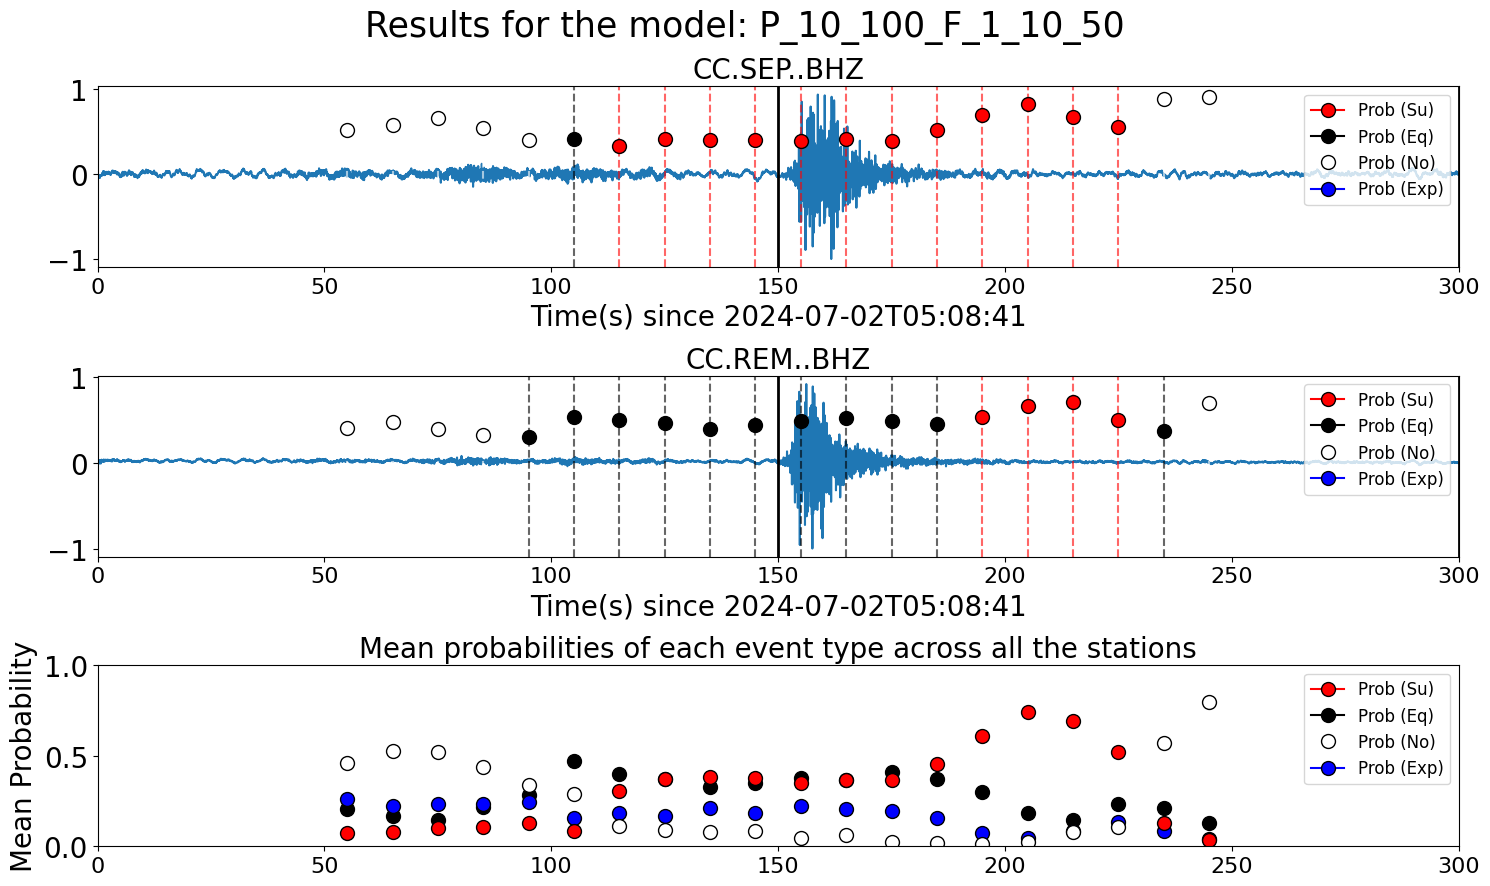

100%|██████████| 31/31 [00:00<00:00, 323441.35it/s]

100%|██████████| 31/31 [00:00<00:00, 391636.82it/s]

1 Trace(s) in Stream:
CC.SEP..BHZ | 2024-07-02T05:08:41.000000Z - 2024-07-02T05:13:41.010000Z | 100.0 Hz, 30002 samples



100%|██████████| 31/31 [00:00<00:00, 372559.95it/s]

100%|██████████| 31/31 [00:00<00:00, 405057.40it/s]

1 Trace(s) in Stream:
CC.REM..BHZ | 2024-07-02T05:08:41.000000Z - 2024-07-02T05:13:41.010000Z | 100.0 Hz, 30002 samples



 50%|█████     | 3/6 [00:11<00:10,  3.39s/it]

0 Trace(s) in Stream:



 67%|██████▋   | 4/6 [00:12<00:04,  2.36s/it]

0 Trace(s) in Stream:



 83%|████████▎ | 5/6 [00:13<00:01,  1.80s/it]

0 Trace(s) in Stream:



100%|██████████| 6/6 [00:14<00:00,  2.43s/it]

0 Trace(s) in Stream:



16


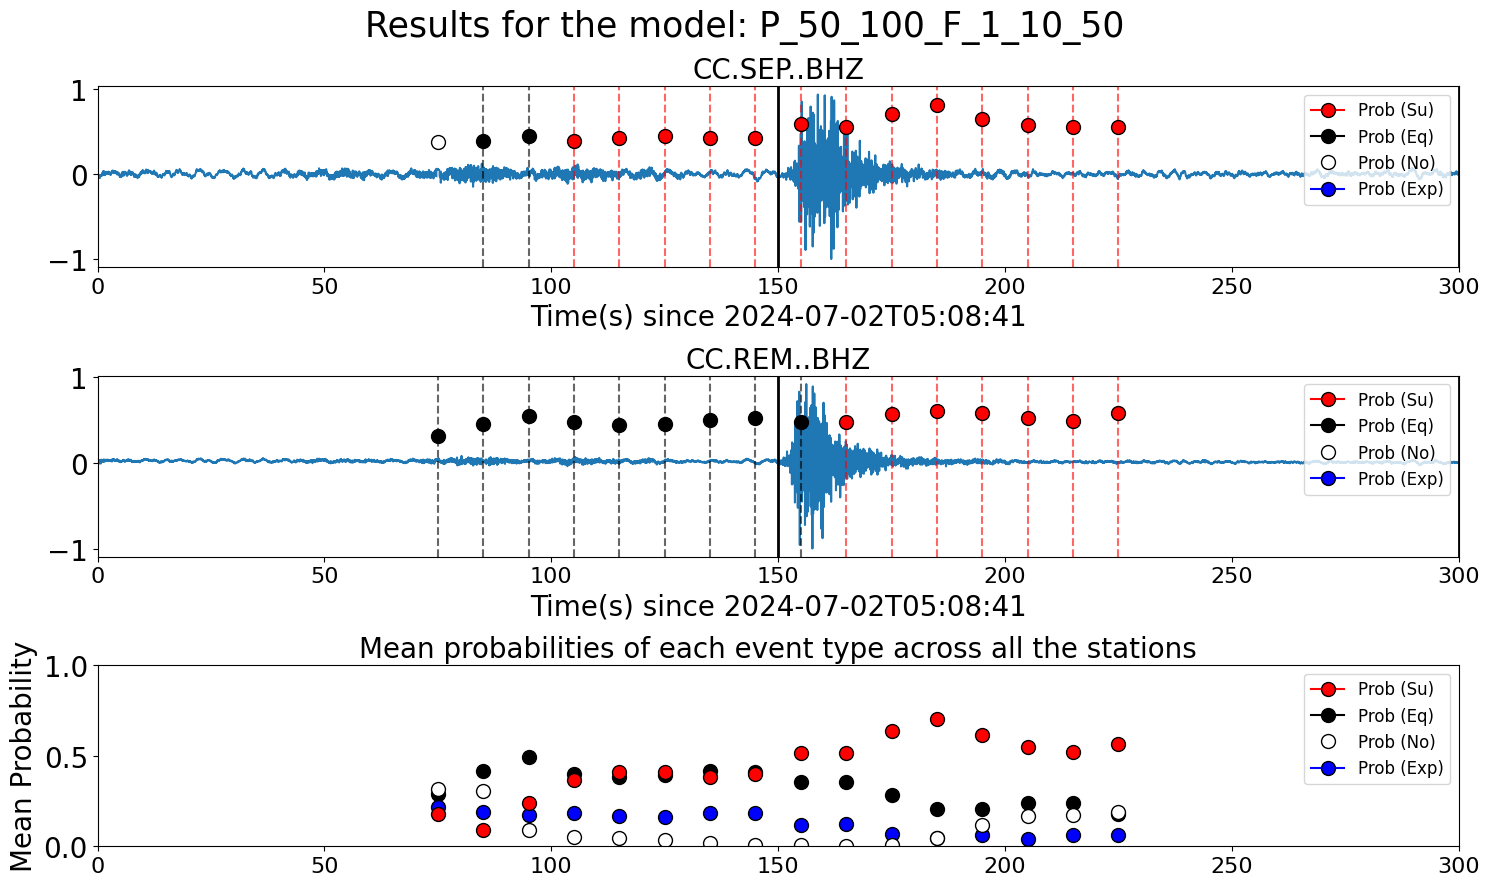

In [13]:
## Parameters to set before running this script. 
filename = 'P_10_30_F_1_15_50'

result_stns, index_stns, prob_stns, st_overall, st_overall_data, st_overall_times  = surface_event_detection(starttime = starttime, stations_id = stations_id, dur = dur, stride = stride,
                            location = location, filename = filename)

plot_detection_results(st_overall_data = st_overall_data, st_overall_times = st_overall_times, st_overall = st_overall, result_stns = result_stns, index_stns = index_stns, prob_stns = prob_stns, xlim = [0,dur], ev_markers = [before,dur], shift = stride, filename = filename)



## Parameters to set before running this script. 
filename = 'P_10_100_F_1_10_50'
result_stns, index_stns, prob_stns, st_overall, st_overall_data, st_overall_times  = surface_event_detection(starttime = starttime, stations_id = stations_id, dur = dur, stride = stride,
                            location = location, filename = filename)

plot_detection_results(st_overall_data = st_overall_data, st_overall_times = st_overall_times, st_overall = st_overall, result_stns = result_stns, index_stns = index_stns, prob_stns = prob_stns, xlim = [0,dur], ev_markers = [before,dur], shift = stride, filename = filename)




## Parameters to set before running this script. 
filename = 'P_50_100_F_1_10_50'
result_stns, index_stns, prob_stns, st_overall, st_overall_data, st_overall_times  = surface_event_detection(starttime = starttime, stations_id = stations_id, dur = dur, stride = stride,
                            location = location, filename = filename)

plot_detection_results(st_overall_data = st_overall_data, st_overall_times = st_overall_times, st_overall = st_overall, result_stns = result_stns, index_stns = index_stns, prob_stns = prob_stns, xlim = [0,dur], ev_markers = [before,dur], shift = stride, filename = filename)




## Plotting the results

In [ ]:
plot_detection_results(st_overall_data = st_overall_data, st_overall_times = st_overall_times, st_overall = st_overall, result_stns = result_stns, index_stns = index_stns, prob_stns = prob_stns, xlim = [0,dur], ev_markers = [before,dur], shift = stride)

##### 

## Deleting the downloaded files

In [14]:
import os

# Get the current working directory
directory = os.getcwd()

# List of file extensions to delete
extensions_to_delete = [".joblib", ".csv"]

# List the files in the directory
files = os.listdir(directory)

# Iterate over the files and delete those with specified extensions
for file in files:
    if any(file.endswith(ext) for ext in extensions_to_delete):
        file_path = os.path.join(directory, file)
        try:
            os.remove(file_path)
            print(f"Deleted {file_path}")
        except OSError as e:
            print(f"Error deleting {file_path}: {e}")


Deleted /home/ak287/PNW_Seismic_Event_Classification/notebooks/best_rf_model_all_features_P_10_30_F_1_15_50.joblib
Deleted /home/ak287/PNW_Seismic_Event_Classification/notebooks/best_rf_model_all_features_P_50_100_F_1_10_50.joblib
Deleted /home/ak287/PNW_Seismic_Event_Classification/notebooks/scaler_params_P_10_100_F_1_10_50.csv
Deleted /home/ak287/PNW_Seismic_Event_Classification/notebooks/best_rf_model_all_features_P_10_100_F_1_10_50.joblib
Deleted /home/ak287/PNW_Seismic_Event_Classification/notebooks/scaler_params_P_10_30_F_1_15_50.csv
Deleted /home/ak287/PNW_Seismic_Event_Classification/notebooks/scaler_params_P_50_100_F_1_10_50.csv
